In [48]:
# !pip install tensorflow-gpu

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd

2024-02-07 14:12:23.453658: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 14:12:23.487357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 14:12:23.487398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 14:12:23.488085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 14:12:23.493016: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 14:12:23.493670: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [8]:
# Read the shapefile
# Flooded = 0 indicates not flooded location while Flooded = 1 indicates flooded location
df=gpd.read_file("Study_area_AN.shp") 
df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,...,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text,geometry
0,74,ETH,Ethiopia,2,Afar,10,Zone 3,42,Amibara,Woreda,...,2.290610,270.0,-0.64,0,78,9.954030,9.216515,40,4,"POLYGON ((621057.000 1024697.907, 620743.309 1..."
1,74,ETH,Ethiopia,2,Afar,10,Zone 3,42,Amibara,Woreda,...,3.433630,180.0,-0.00,0,78,15.349070,9.216515,40,4,"POLYGON ((621057.000 1024697.907, 620743.309 1..."
2,74,ETH,Ethiopia,2,Afar,10,Zone 3,42,Amibara,Woreda,...,0.810231,315.0,-0.00,0,30,11.934627,8.994308,40,1,"POLYGON ((621057.000 1024697.907, 620743.309 1..."
3,74,ETH,Ethiopia,2,Afar,10,Zone 3,42,Amibara,Woreda,...,2.429397,225.0,-1.28,0,58,13.936107,9.216515,40,4,"POLYGON ((621057.000 1024697.907, 620743.309 1..."
4,74,ETH,Ethiopia,2,Afar,10,Zone 3,42,Amibara,Woreda,...,0.000000,-9999.0,-0.00,0,58,13.726386,8.994308,40,4,"POLYGON ((621057.000 1024697.907, 620743.309 1..."


In [9]:
df= df.drop(labels = ["index_righ","Soil_Test","id","geometry","NAME_0","ID_0","ISO","ID_1","NAME_1","ID_2","NAME_2","ID_3","NAME_3","TYPE_3","ENGTYPE_3","NL_NAME_3","VARNAME_3"], axis=1) # we need to remove all the columns except the predictive features
df.head()

,label,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text
0,1,728,2.290610,270.0,-0.64,78,9.954030,9.216515,40,4
1,1,729,3.433630,180.0,-0.00,78,15.349070,9.216515,40,4
2,1,727,0.810231,315.0,-0.00,30,11.934627,8.994308,40,1
3,1,727,2.429397,225.0,-1.28,58,13.936107,9.216515,40,4
4,1,728,0.000000,-9999.0,-0.00,58,13.726386,8.994308,40,4


In [10]:
print(df.describe().T)  #Values are already normalized in GIS before fitting. 

           count          mean           std           min         25%  \
label      392.0  6.938776e-01  4.614702e-01  0.000000e+00    0.000000   
DEM        392.0  7.298801e+02  4.764391e+01  6.960000e+02  706.000000   
Slope      392.0  4.344356e+00  5.118865e+00  0.000000e+00    1.811248   
Aspect     392.0 -7.212883e+02  2.910409e+03 -9.999000e+03   70.374138   
Curvature  392.0  6.857143e-02  8.645469e-01 -2.560000e+00   -0.640000   
CN         392.0  6.034184e+01  1.045563e+01  3.000000e+01   58.000000   
TWI        392.0 -8.680671e+19  1.718685e+21 -3.402823e+22    6.958297   
Rainfall   392.0  1.191072e+01  2.371323e+00  6.662645e+00   10.237988   
LULC       392.0  4.214286e+01  2.635582e+01  2.000000e+01   20.000000   
Soil_Text  392.0  4.176020e+00  1.420398e+00  1.000000e+00    4.000000   

                  50%         75%          max  
label        1.000000    1.000000     1.000000  
DEM        715.000000  728.000000  1042.000000  
Slope        2.918995    4.573921    3

In [11]:
## Check if there is null values
print(df.isnull().sum())
#df = df.dropna()

label        0
DEM          0
Slope        0
Aspect       0
Curvature    0
CN           0
TWI          0
Rainfall     0
LULC         0
Soil_Text    0
dtype: int64


In [12]:
df["label"]

0      1
1      1
2      1
3      1
4      1
      ..
387    1
388    1
389    1
390    1
391    1
Name: label, Length: 392, dtype: int64

In [13]:
#df = merged.rename(columns={'FSM':'Label'})
print(df.dtypes)

label          int64
DEM            int64
Slope        float64
Aspect       float64
Curvature    float64
CN             int64
TWI          float64
Rainfall     float64
LULC           int64
Soil_Text      int64
dtype: object


<Axes: xlabel='label', ylabel='count'>

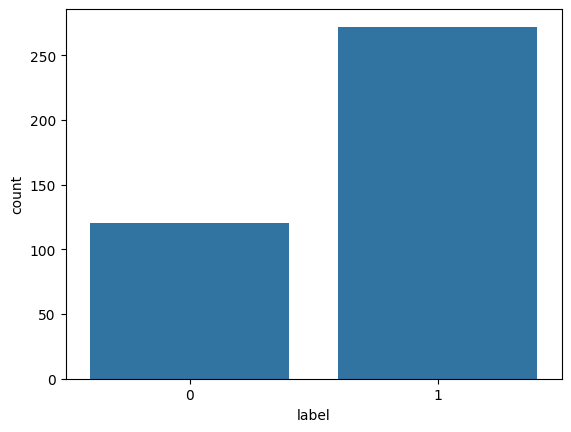

In [14]:
#Understand the data 
# The dataset includes the same number of flooded and not flooded locations
sns.countplot(x="label", data=df) #0 - Notflooded   1 - Flooded

<Axes: >

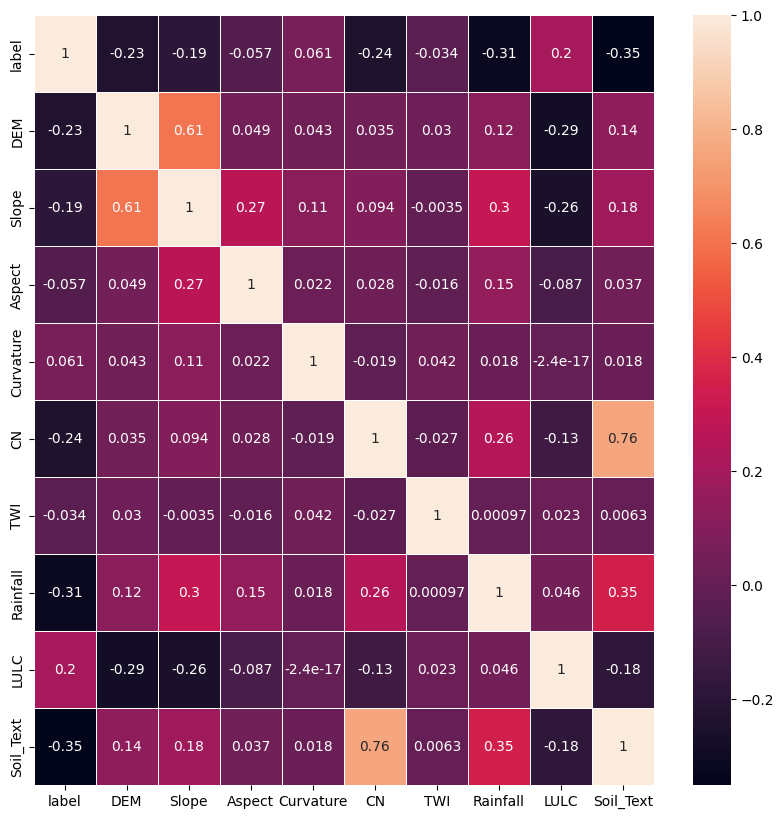

In [15]:
# Correlation between the input features

# corrMatrix = df.corr()
# fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
# #sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
# sns.heatmap(corrMatrix, annot=False, linewidths=.5, ax=ax)
# Select only the numeric columns from the dataframe
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corrMatrix = numeric_df.corr()

# Now you can create the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)


In [18]:
#Define the dependent variable that needs to be predicted (labels)
Y = df["label"].values


In [19]:
#Define the independent variables. 
X = df.drop(labels = ["label"], axis=1) 
features_list = list(X.columns)  #List features so we can rank them later.
from sklearn.preprocessing import normalize
# Only needed if the data was not normalized
# X = normalize(X, axis=1)

In [20]:
# the independent variables
X

,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text
0,728,2.290610,270.000000,-0.64,78,9.954030,9.216515,40,4
1,729,3.433630,180.000000,-0.00,78,15.349070,9.216515,40,4
2,727,0.810231,315.000000,-0.00,30,11.934627,8.994308,40,1
3,727,2.429397,225.000000,-1.28,58,13.936107,9.216515,40,4
4,728,0.000000,-9999.000000,-0.00,58,13.726386,8.994308,40,4
...,...,...,...,...,...,...,...,...,...
387,700,3.337111,30.963757,1.28,66,13.221696,11.852880,20,4
388,702,3.237688,135.000000,1.28,66,8.790391,11.852880,90,4
389,701,2.290610,360.000000,-0.64,66,10.012921,11.852880,20,4
390,700,2.560639,26.565046,0.64,66,11.711483,11.852880,20,4


In [21]:
# the dependent variable
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [22]:
#Split data into train, validation and test to verify accuracy after fitting the model. 
# Firstly split the data into train_validation and test datasets then split the train_validation dataset into train and validation datasets.
# The training dataset is used to train the model, the validation dataset is used for hyperparamter tuning and the testing dataset is used to test the model.
# It is recommended to test the model with a data that the model hasn't seen in the training process
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2,shuffle=True, random_state=42)


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,shuffle=True, random_state=42)

In [24]:
print(X_train.shape)

(234, 9)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))



In [26]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_val, y_val),verbose=0)


In [27]:
# Model prediction
predictions = model.predict(X_test)

# Round the predictions to 1 (Flooded) or 0 (Not flooded)
rounded_predictions = [1 if pred > 0.6 else 0 for pred in predictions]

# Display the rounded predictions
print(rounded_predictions)


3/3 [==============================] - 1s 4ms/step
[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1]


In [28]:
predictions

array([[ 0.77809834],
       [ 0.29765087],
       [ 0.7292698 ],
       [ 0.6422999 ],
       [ 0.6554794 ],
       [ 0.4921569 ],
       [ 0.8067253 ],
       [ 0.6087509 ],
       [ 0.18945938],
       [ 0.73904324],
       [ 1.0247872 ],
       [ 0.36619118],
       [-0.06662913],
       [ 0.71819276],
       [ 0.5932287 ],
       [-0.01899536],
       [ 0.69521874],
       [ 0.47929543],
       [ 0.77965826],
       [-0.07797959],
       [ 1.1717447 ],
       [ 0.8188373 ],
       [ 0.42091048],
       [ 0.8280156 ],
       [ 0.5650957 ],
       [ 0.6234671 ],
       [ 0.92490673],
       [ 0.93197316],
       [ 0.29703015],
       [ 0.56197065],
       [ 0.48288855],
       [ 0.79845434],
       [-0.05881825],
       [ 0.27386132],
       [ 0.98158514],
       [ 0.3951952 ],
       [ 0.74251163],
       [ 0.8027525 ],
       [ 0.7765186 ],
       [ 0.95335793],
       [ 0.6988915 ],
       [ 0.20441239],
       [ 0.14647013],
       [ 1.0235106 ],
       [ 0.64915633],
       [ 0

In [29]:
# Scale the input features to a specific range (e.g., [0, 1])
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3/3 [==============================] - 0s 3ms/step


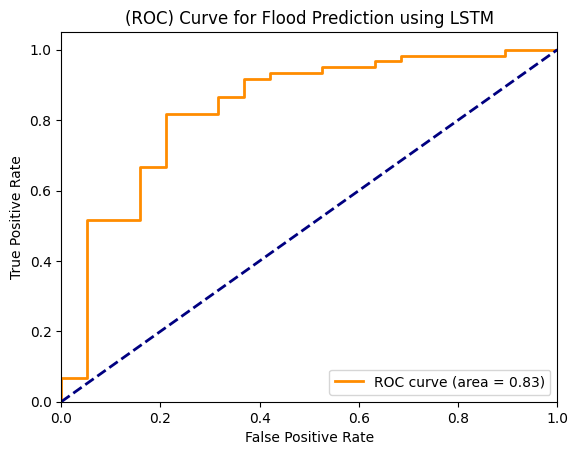

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have already trained a model and obtained predictions
# Replace 'model' with the name of your trained LSTM model and X_test, y_test with your test data
y_pred_prob = model.predict(X_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Flood Prediction using LSTM')
plt.legend(loc="lower right")
plt.show()


3/3 [==============================] - 0s 3ms/step


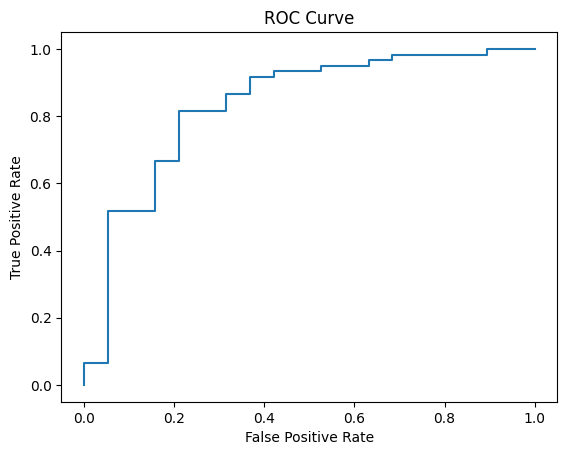

In [31]:
# In order to map the flood susceptibility, we need to predict the flood susceptibility (probability between 0 and 1)
# Assuming you have already trained an LSTM model and obtained predictions
# Replace 'model' with the name of your trained LSTM model and X_test with your test data
prediction_prob=model.predict(X_test)
# prediction_prob now contains the predicted probabilities for flood susceptibility
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test)[:,0])

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [32]:
prediction_prob

array([[ 0.77809834],
       [ 0.29765087],
       [ 0.7292698 ],
       [ 0.6422999 ],
       [ 0.6554794 ],
       [ 0.4921569 ],
       [ 0.8067253 ],
       [ 0.6087509 ],
       [ 0.18945938],
       [ 0.73904324],
       [ 1.0247872 ],
       [ 0.36619118],
       [-0.06662913],
       [ 0.71819276],
       [ 0.5932287 ],
       [-0.01899536],
       [ 0.69521874],
       [ 0.47929543],
       [ 0.77965826],
       [-0.07797959],
       [ 1.1717447 ],
       [ 0.8188373 ],
       [ 0.42091048],
       [ 0.8280156 ],
       [ 0.5650957 ],
       [ 0.6234671 ],
       [ 0.92490673],
       [ 0.93197316],
       [ 0.29703015],
       [ 0.56197065],
       [ 0.48288855],
       [ 0.79845434],
       [-0.05881825],
       [ 0.27386132],
       [ 0.98158514],
       [ 0.3951952 ],
       [ 0.74251163],
       [ 0.8027525 ],
       [ 0.7765186 ],
       [ 0.95335793],
       [ 0.6988915 ],
       [ 0.20441239],
       [ 0.14647013],
       [ 1.0235106 ],
       [ 0.64915633],
       [ 0

In [34]:
ls=prediction_prob[:,0]
ls.shape

(79,)

In [35]:
# Assuming you have obtained the predicted probabilities in prediction_prob
# Set a threshold to convert probabilities to class labels (e.g., 0.5 for binary classification)
# threshold = 0.4
# prediction = (prediction_prob > threshold).astype(int)

# Now you can generate the classification report using the predicted class labels
from sklearn.metrics import classification_report
target_names = ["Not Flooded", "Flooded"]
print(classification_report(y_test, rounded_predictions, target_names=target_names))


              precision    recall  f1-score   support

 Not Flooded       0.56      0.79      0.65        19
     Flooded       0.92      0.80      0.86        60

    accuracy                           0.80        79
   macro avg       0.74      0.79      0.75        79
weighted avg       0.83      0.80      0.81        79



In [36]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, rounded_predictions))

0.5153374233128833


In [37]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, rounded_predictions)
print(cm)

[[15  4]
 [12 48]]


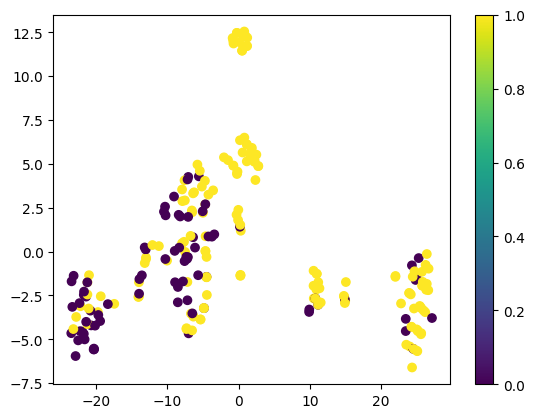

In [38]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

# Assuming X_train is the input training data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

# Apply t-SNE to the normalized data
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train_normalized)

# Visualize the learned representations using t-SNE
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.show()


#Amibara

In [39]:
# !pip3 install pickle5
import pickle

In [40]:
with open('points_data.pkl', "rb") as fh:
  df = pickle.load(fh)
df

,id,label,geometry,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text
0,0,0,POINT (648355.689 1032128.503),810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7
1,1,0,POINT (652338.758 1039898.468),798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7
2,2,0,POINT (654594.349 1045368.461),783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7
3,3,0,POINT (653891.492 1031276.320),845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7
4,4,0,POINT (657859.303 1042542.024),803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,496,1,POINT (634272.168 1036892.731),719,0.000000,-9999.000000,-0.00,0,30,9.554776,10.237988,90,1
389,497,1,POINT (634203.006 1037288.382),720,1.811248,161.565048,-0.64,0,30,6.938687,10.237988,30,1
390,498,1,POINT (632194.606 1037854.806),721,0.000000,-9999.000000,-0.00,0,58,7.469123,10.237988,40,4
391,499,1,POINT (635526.358 1042630.752),715,0.000000,-9999.000000,-0.00,0,58,14.062859,14.165248,90,4


In [41]:
X_hotspot0= df.drop(labels = ["geometry"], axis=1) 
X_hotspot0.head()

,id,label,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text
0,0,0,810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7
1,1,0,798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7
2,2,0,783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7
3,3,0,845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7
4,4,0,803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7


In [42]:
cols=X.columns
cols

Index(['DEM', 'Slope', 'Aspect', 'Curvature', 'CN', 'TWI', 'Rainfall', 'LULC',
       'Soil_Text'],
      dtype='object')

In [43]:
X_hotspot0=X_hotspot0[cols]
X_hotspot0

,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text
0,810,4.124518,56.309933,1.28,71,7.651444,8.634620,30,7
1,798,1.811248,288.434937,-0.64,71,6.457982,9.113000,30,7
2,783,2.429397,45.000000,-1.28,71,8.626627,14.380471,30,7
3,845,0.810231,225.000000,-0.00,71,11.018336,9.009209,30,7
4,803,1.811248,108.434952,-0.64,71,7.151129,11.598495,30,7
...,...,...,...,...,...,...,...,...,...
388,719,0.000000,-9999.000000,-0.00,30,9.554776,10.237988,90,1
389,720,1.811248,161.565048,-0.64,30,6.938687,10.237988,30,1
390,721,0.000000,-9999.000000,-0.00,58,7.469123,10.237988,40,4
391,715,0.000000,-9999.000000,-0.00,58,14.062859,14.165248,90,4


In [44]:
print(X_hotspot0.isnull().sum())

DEM          0
Slope        0
Aspect       0
Curvature    0
CN           0
TWI          0
Rainfall     0
LULC         0
Soil_Text    0
dtype: int64


In [45]:
X_hotspot0 = X_hotspot0.dropna()

In [46]:
df=df.dropna()

In [47]:
prediction_prob=model.predict(X_hotspot0)

13/13 [==============================] - 0s 3ms/step


In [48]:
prediction_prob

array([[ 0.6160304 ],
       [ 0.29703015],
       [ 0.3454358 ],
       [ 0.41642788],
       [ 0.3498416 ],
       [ 0.11516511],
       [ 0.41948667],
       [ 0.56700706],
       [ 0.15089214],
       [-0.04833654],
       [ 0.20003329],
       [ 0.39122587],
       [ 0.6197251 ],
       [ 0.09054514],
       [ 0.39981055],
       [ 0.7200898 ],
       [ 0.7546379 ],
       [ 0.6965957 ],
       [ 0.09681   ],
       [ 0.29765314],
       [ 0.00458598],
       [ 0.16473162],
       [ 0.6638665 ],
       [ 0.7505042 ],
       [ 0.393276  ],
       [ 0.5649886 ],
       [ 0.2609987 ],
       [-0.00671418],
       [ 0.40767634],
       [ 0.66609   ],
       [ 0.48841766],
       [ 0.7471176 ],
       [ 0.453772  ],
       [ 0.50451857],
       [ 0.29653966],
       [ 0.64150476],
       [ 0.0655905 ],
       [ 0.31395975],
       [ 0.25127298],
       [ 0.51033205],
       [ 0.2192895 ],
       [ 0.16620396],
       [ 0.7028418 ],
       [ 0.20441239],
       [ 0.13915251],
       [ 0

In [49]:
ls_hotspot0=prediction_prob[:,0]
ls_hotspot0

array([ 0.6160304 ,  0.29703015,  0.3454358 ,  0.41642788,  0.3498416 ,
        0.11516511,  0.41948667,  0.56700706,  0.15089214, -0.04833654,
        0.20003329,  0.39122587,  0.6197251 ,  0.09054514,  0.39981055,
        0.7200898 ,  0.7546379 ,  0.6965957 ,  0.09681   ,  0.29765314,
        0.00458598,  0.16473162,  0.6638665 ,  0.7505042 ,  0.393276  ,
        0.5649886 ,  0.2609987 , -0.00671418,  0.40767634,  0.66609   ,
        0.48841766,  0.7471176 ,  0.453772  ,  0.50451857,  0.29653966,
        0.64150476,  0.0655905 ,  0.31395975,  0.25127298,  0.51033205,
        0.2192895 ,  0.16620396,  0.7028418 ,  0.20441239,  0.13915251,
        0.12386222,  0.5650957 ,  0.63668245,  1.0235106 ,  0.72841316,
        0.7609657 ,  0.7468662 ,  0.75920534,  0.74251163,  0.6332323 ,
        0.7626416 ,  0.7309342 ,  0.68711215,  0.4558763 ,  0.01328942,
        0.6163484 ,  0.33079332,  0.37812454,  0.5849568 ,  0.31336495,
        0.3104922 ,  0.12941496,  0.27386132, -0.21378721,  0.04

In [50]:
df['FSM']=ls_hotspot0
df

,id,label,geometry,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text,FSM
0,0,0,POINT (648355.689 1032128.503),810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7,0.616030
1,1,0,POINT (652338.758 1039898.468),798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7,0.297030
2,2,0,POINT (654594.349 1045368.461),783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7,0.345436
3,3,0,POINT (653891.492 1031276.320),845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7,0.416428
4,4,0,POINT (657859.303 1042542.024),803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7,0.349842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,496,1,POINT (634272.168 1036892.731),719,0.000000,-9999.000000,-0.00,0,30,9.554776,10.237988,90,1,1.074096
389,497,1,POINT (634203.006 1037288.382),720,1.811248,161.565048,-0.64,0,30,6.938687,10.237988,30,1,0.818679
390,498,1,POINT (632194.606 1037854.806),721,0.000000,-9999.000000,-0.00,0,58,7.469123,10.237988,40,4,0.814813
391,499,1,POINT (635526.358 1042630.752),715,0.000000,-9999.000000,-0.00,0,58,14.062859,14.165248,90,4,0.604932


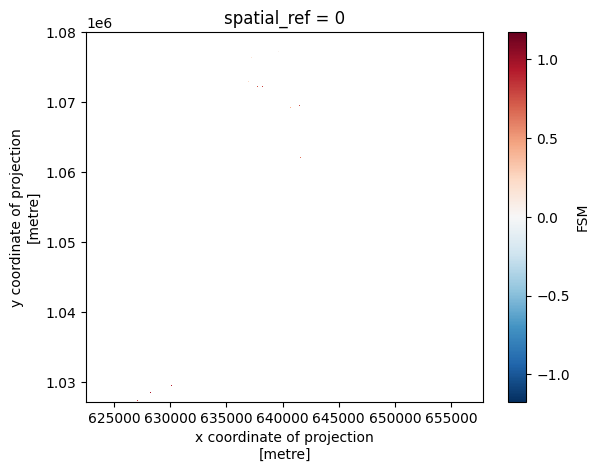

In [59]:
%matplotlib inline

import geocube
from geocube.api.core import make_geocube

geo_grid = make_geocube(
    vector_data=df,
    measurements=['FSM'],
    resolution=(-12.5, 12.5)
)

# Get the CRS information from the original GeoDataFrame
#crs = df.crs

# Save the raster with proper CRS information
#geo_grid["FSM"].rio.to_raster("Flood_susceptibility_LSTM.tif", crs=crs)
# df.plot(df)
geo_grid.FSM.plot()

In [97]:
# !pip install --upgrade rasterio

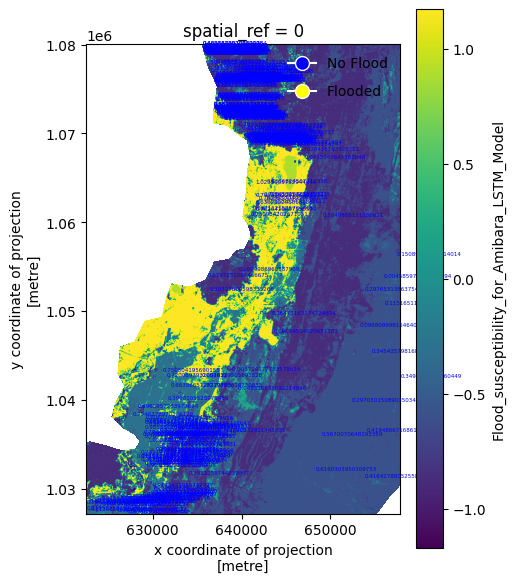

In [58]:
import geocube
from geocube.api.core import make_geocube
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.plot import show

# Assuming df is a GeoDataFrame with your vector data

# Create a GeoCube
geo_grid = make_geocube(
    vector_data=df,
    measurements=['FSM'],
    resolution=(-12.5, 12.5)
)

# Extract the raster data
raster_data = geo_grid.compute()

# Assuming LULC.tif is your LULC raster file with RGB values
lulc_path = "LULC.tif"
lulc_data = rasterio.open(lulc_path)

# Plot the raster data on a map
fig, ax = plt.subplots(figsize=(5, 7))  # Adjust the size of the map

# Assuming the raster_data is a DataArray with the 'label' variable
im1 = raster_data.FSM.plot(ax=ax, cmap='viridis', add_colorbar=False)

# Optionally, overlay your vector data on the map
#df.plot(ax=ax, color='yellow', alpha=0.5, edgecolor='black')

# Add labels for points
for idx, row in df.iterrows():
    color = 'yellow' if row['FSM'] == 1 else 'blue'
    ax.text(row.geometry.x, row.geometry.y, str(row['FSM']), color=color, fontsize=4)

# Add legends for flood and no flood with distinct colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10)]
legend_labels = {0: 'No Flood', 1: 'Flooded'}
ax.legend(legend_handles, legend_labels.values(), scatterpoints=1, frameon=False, labelspacing=1, loc='upper right')

# Show the LULC raster with RGB values
show(lulc_data, ax=ax)

# Add default legends for the raster data
cbar = plt.colorbar(im1, ax=ax, pad=0.04)
cbar.set_label('Flood_susceptibility_for_Amibara_LSTM_Model')

# # Set the legend ticks and labels
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['Min', 'Max'])

# # Adjust the extent of the map
# ax.set_xlim(lulc_data.bounds.left.min(), lulc_data.bounds.right.max())
# ax.set_ylim(lulc_data.bounds.bottom.min(), lulc_data.bounds.top.max())

# Show the map
plt.show()

In [ ]:
geo_grid.FSM.rio.to_raster("FSM.tif")
